In [1]:

import matplotlib.pyplot as plt
import scipy as sy
import numpy as np
from math import sqrt, log
from tqdm import tqdm
from src.py_utils import *

# Tomography

In [2]:
fidelities = {}
nshots = {}
noisy_fidelities_Brisbane = {}
noisy_fidelities_Sherbrooke = {}
noisy_fidelities_Kyiv = {}

Range_tomo = np.arange(2, 7)
for i in Range_tomo:
    fn = f'data/fidelities_n={i}_range={100}_{100}_{30000}.dat' 
    if i==4:
        fn = f'data/fidelities_n={i}_range={100}_{100}_{30000}_log.dat' 
    elif i==5:
        fn = f'data/fidelities_n={i}_range={1}_{100000}.dat' 
    elif i==6:
        fn = f'data/fidelities_n={i}_range={100}_{300}_{95000}_log.dat' 

    with open(fn, 'r') as f:
        data = np.loadtxt(f)
        tmp_nshots = data[:, 0]
        tmp_fidelities = data[:, 1]
        tmp_noisy_fidelities_Brisbane = data[:, 2]
        tmp_noisy_fidelities_Sherbrooke = data[:, 3]
        tmp_noisy_fidelities_Kyiv = data[:, 4]
    # plt.plot(nshots, fidelities, label=f'{i} noiseless')
    # plt.plot(nshots, noisy_fidelities_Brisbane, label=f'{i} Brisbane')
    # plt.plot(nshots, noisy_fidelities_Kyiv, '--', label=f'{i} Kyiv')
    # plt.plot(nshots, noisy_fidelities_Sherbrooke, label=f'{i} Sherbrooke')
    # plt.xscale('log')
    nshots[i] = tmp_nshots
    fidelities[i] = tmp_fidelities
    noisy_fidelities_Brisbane[i] = tmp_noisy_fidelities_Brisbane
    noisy_fidelities_Sherbrooke[i] = tmp_noisy_fidelities_Sherbrooke
    noisy_fidelities_Kyiv[i] = tmp_noisy_fidelities_Kyiv



In [3]:
super_fid_tomo = {'Noiseless QASM simulator': fidelities, 'Brisbane backend': noisy_fidelities_Brisbane, 'Kyiv backend': noisy_fidelities_Kyiv, 'Sherbrooke backend': noisy_fidelities_Sherbrooke}

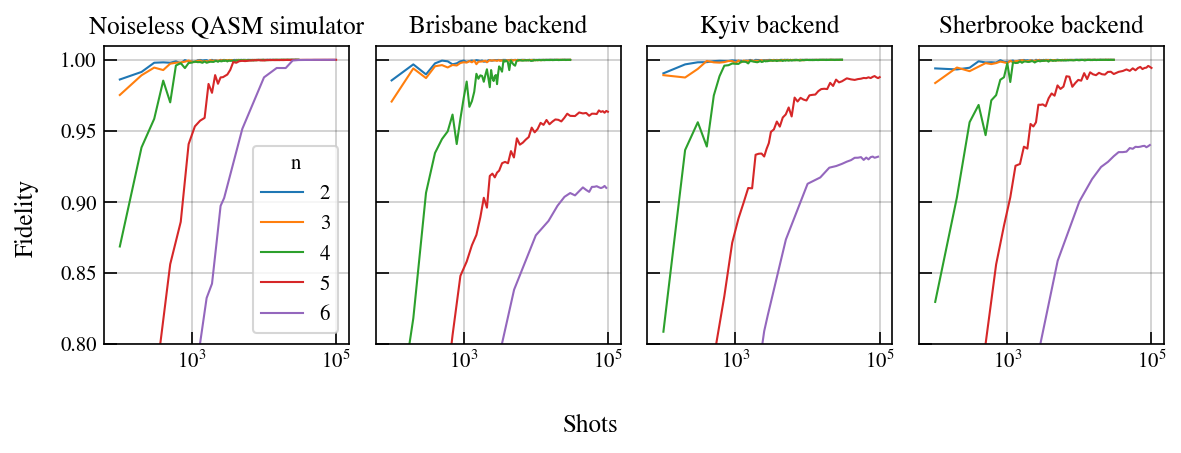

In [40]:
plt.style.use('style_v1.mplstyle')

fig, axs = plt.subplots(1, 4, sharey=True, sharex=True, figsize=(8,3))

i = 0
for name, vals in super_fid_tomo.items():
    for j in Range_tomo:
        axs[i].semilogx(nshots[j], vals[j], label=f'{j}')
    axs[i].set_title(name)
    axs[i].grid()
    axs[i].set_xlim(60, 1.5e5)
    axs[i].set_ylim(0.8, 1.01)
    # axs[i].set_yscale('log')
    i += 1

axs[0].legend(title='n')
fig.supylabel('Fidelity')
fig.supxlabel('Shots')
fig.tight_layout()
fig.savefig('plots/tot_comparison.pdf')

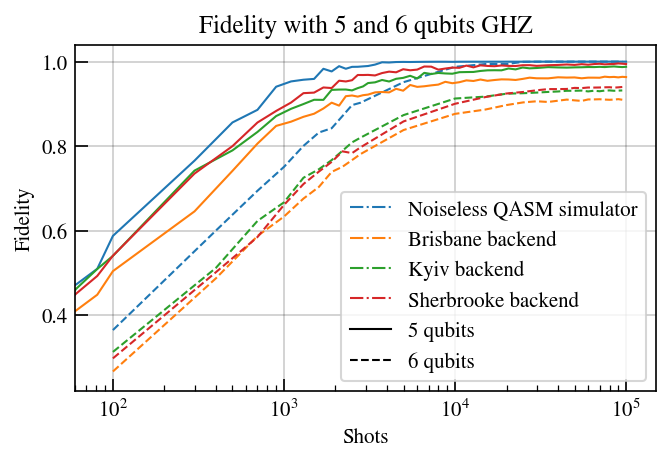

In [383]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
i = 0
for name, vals in super_fid_tomo.items():
    plt.semilogx(nshots[6], vals[6], '--', color=colors[i])#, label=f'6 qubits {name}')
    plt.semilogx(nshots[5], vals[5], '-', color=colors[i])#, label=f'5 qubits {name}')
    plt.semilogx(1e3, 0, '-.', color=colors[i], label=f'{name}')
    i+=1


plt.semilogx(1e3, 0, 'k-', label=f'5 qubits')
plt.semilogx(1e3, 0, 'k--', label=f'6 qubits')

plt.title('Fidelity with 5 and 6 qubits GHZ')
plt.legend()
plt.ylabel('Fidelity')
plt.xlabel('Shots')
plt.ylim(0.22, 1.04)
plt.xlim(60, 1.5e5)
plt.grid()
plt.savefig('plots/tomo_5vs6.pdf')

In [411]:
threshold = 0.94
min_nshots = {}
for name, vals in super_fid_tomo.items():
    tmp_min_shots = []
    for i in Range_tomo:
        try:
            idx = np.argwhere(vals[i]>threshold)[0][0]
            tmp_min_shots.append(nshots[i][idx])
        except Exception:
            tmp_min_shots.append(-1)
    min_nshots[name] = np.array(tmp_min_shots)

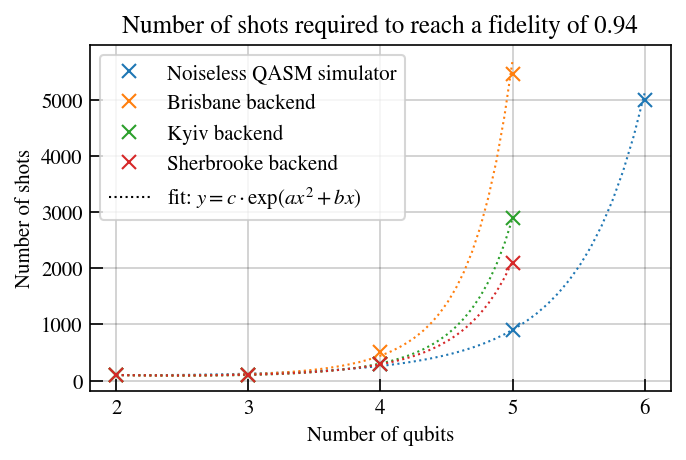

In [412]:
i = 0
for name, vals in min_nshots.items():
    fit = np.polyfit(Range_tomo[vals>0], np.log(vals[vals>0]), 2)
    x = np.linspace(2, len(vals[vals>0])+1)
    fit_vals = np.polyval(fit, x)
    plt.plot(Range_tomo[vals>0], vals[vals>0], 'x', markersize=7, color=colors[i], label=f'{name}')
    plt.plot(x, np.exp(fit_vals), ':', markersize=7, color=colors[i])
    i += 1

plt.plot(2, 1000, 'k:', label=r'fit: $y=c\cdot\exp(ax^2+bx)$')

plt.title(f'Number of shots required to reach a fidelity of {threshold}')
plt.xlabel('Number of qubits')
plt.ylabel('Number of shots')
plt.xticks(Range_tomo)
plt.legend()
# plt.ylim(0, 2000)
plt.grid()
plt.savefig('plots/shots_required_0.95.pdf')

# Classical shadows

In [2]:
clsh = {}
noisy_clsh = {}

Range = np.concatenate((np.arange(2, 8), [18, 20]))

for i in Range:
    if i==4 or i==6:
        fn_QASM = f'data/fidelities_n={i}_N=8000_QASM_bis.dat' 
        fn_Br = f'data/fidelities_n={i}_N=8000_Br_bis.dat' 
    else:
        fn_QASM = f'data/fidelities_n={i}_N=8000_QASM.dat' 
        fn_Br = f'data/fidelities_n={i}_N=8000_Br.dat' 
   
    with open(fn_QASM, 'r') as f:
        tmp_clsh = np.loadtxt(f)

    with open(fn_QASM, 'r') as f:
        tmp_noisy_clsh = np.loadtxt(f)
    
    clsh[i] = tmp_clsh
    noisy_clsh[i] = tmp_noisy_clsh
    # plt.plot(nshots, fidelities, label=f'{i} noiseless')
    # plt.plot(nshots, noisy_fidelities_Brisbane, label=f'{i} Brisbane')
    # plt.plot(nshots, noisy_fidelities_Kyiv, '--', label=f'{i} Kyiv')
    # plt.plot(nshots, noisy_fidelities_Sherbrooke, label=f'{i} Sherbrooke')
    # plt.xscale('log')

In [3]:
sizes = np.arange(20, 8001, 76)
sizes = [int(i) for i in np.logspace(np.log10(20), np.log10(8000), 105)]
K = 20

fidelities_noiseless = {}
fidelities_noisy = {}
for n in tqdm(Range):
    tmp_fidelities_noiseless = []
    tmp_fidelities_noisy = []
    for s in tqdm(sizes):
        
        # tmp_fidelities_noiseless.append(median_of_means_fidelity(np.random.choice(clsh[n], size=s), K))
        # tmp_fidelities_noisy.append(median_of_means_fidelity(np.random.choice(noisy_clsh[n], size=s), K))

        tmp_fidelities_noiseless.append(bootstrap_confidence_interval(clsh[n], size=s, K=K))
        tmp_fidelities_noisy.append(bootstrap_confidence_interval(noisy_clsh[n], size=s, K=K))
        
    fidelities_noiseless[n] = np.array(tmp_fidelities_noiseless)
    fidelities_noisy[n] = np.array(tmp_fidelities_noisy)


100%|██████████| 8/8 [03:39<00:00, 27.44s/it]


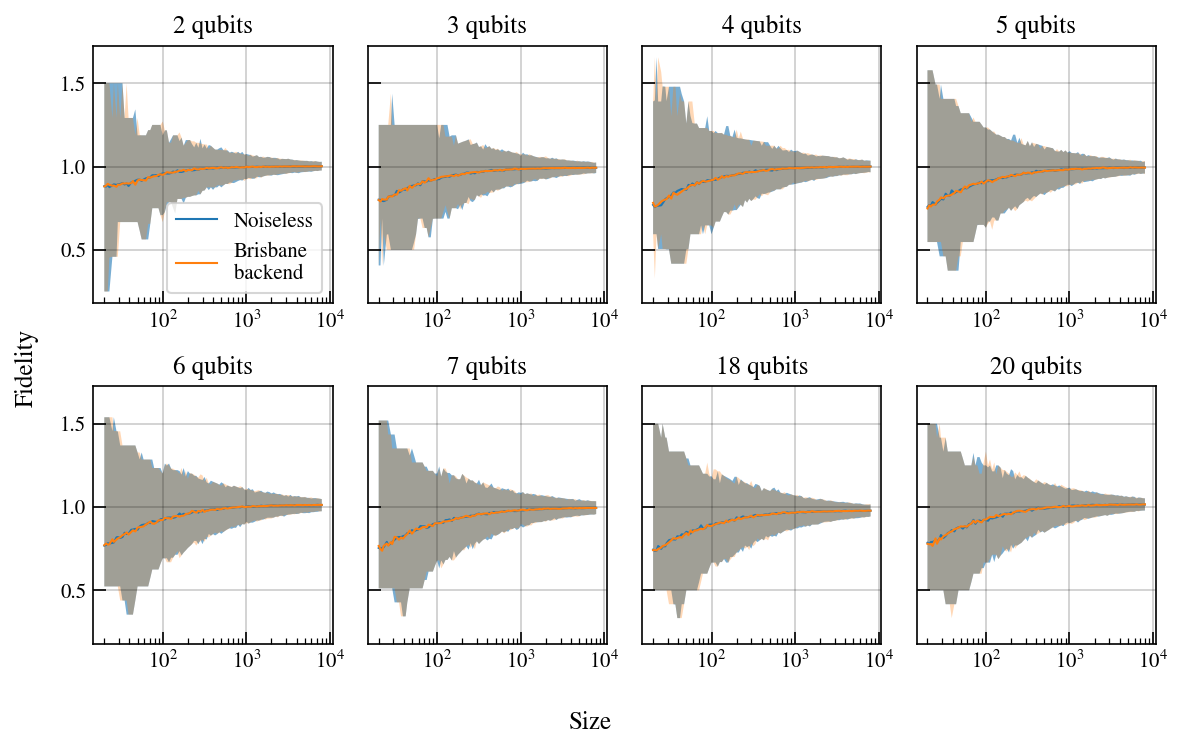

In [4]:
plt.style.use('style_v1.mplstyle')
ncols = len(Range)//2
fig, axs = plt.subplots(2, len(Range)//2, sharey=True, figsize=(8, 5))


for idx, i in enumerate(Range):
    # axs[idx//ncols, idx%ncols].plot(sizes, fidelities_noiseless[i], label='Noiseless')
    # axs[idx//ncols, idx%ncols].plot(sizes, fidelities_noisy[i], label='Brisbane\nbackend')
    err_noiseless = np.transpose(fidelities_noiseless[i][:, 1:])
    err_noisy =  np.transpose(fidelities_noisy[i][:, 1:])
    ## axs[i-3].plot(sizes, fidelities_noiseless[i][:, 0], yerr=err_noiseless, label='Noiseless')
    ## axs[i-3].plot(sizes, fidelities_noisy[i][:, 0], yerr=err_noisy, label='Brisbane\nbackend')
    axs[idx//ncols, idx%ncols].plot(sizes, fidelities_noiseless[i][:, 0], label='Noiseless')
    axs[idx//ncols, idx%ncols].plot(sizes, fidelities_noisy[i][:, 0], label='Brisbane\nbackend')

    axs[idx//ncols, idx%ncols].fill_between(sizes, fidelities_noiseless[i][:, 0]-err_noiseless[0, :], fidelities_noiseless[i][:, 0]+err_noiseless[1, :], alpha=0.6)
    axs[idx//ncols, idx%ncols].fill_between(sizes, fidelities_noisy[i][:, 0]-err_noisy[0, :], fidelities_noisy[i][:, 0]+err_noisy[1, :], alpha=0.3)
    
    axs[idx//ncols, idx%ncols].set_title(f'{i} qubits')
    axs[idx//ncols, idx%ncols].set_xscale('log')
    axs[idx//ncols, idx%ncols].grid()

axs[0, 0].legend()
fig.supxlabel('Size')
fig.supylabel('Fidelity')
fig.tight_layout()
fig.savefig('plots/clsh_fidelities.pdf')

In [422]:
super_fid_clsh = {'Noiseless': fidelities_noiseless, 'Brisbane backend': fidelities_noisy}

eps = 0.06
min_size = {}
for name, vals in super_fid_clsh.items():
    tmp_min_size = []
    for k, v in vals.items():
        # print(vals)
        try:
            v_arr = np.array(v)
            mu = v_arr[:, 0]
            lower = mu-v_arr[:, 1]
            upper = mu+v_arr[:, 2]
            idx = np.argwhere((np.abs(lower-1)<eps) & (np.abs(upper-1)<eps))[0][0]
            tmp_min_size.append(sizes[idx])
        except Exception:
            tmp_min_size.append(-1)
    min_size[name] = np.array(tmp_min_size)

In [423]:
upper

array([1.50000238, 1.50000238, 1.50000238, 1.50000238, 1.50000238,
       1.50000238, 1.50000238, 1.50000238, 1.33333556, 1.33333556,
       1.33333556, 1.33333556, 1.33333556, 1.33333556, 1.33333556,
       1.33333556, 1.33333556, 1.29166885, 1.29166885, 1.25000215,
       1.25000215, 1.25000215, 1.25000215, 1.25000215, 1.30000219,
       1.26666883, 1.2000021 , 1.26666883, 1.25000215, 1.25000215,
       1.25000215, 1.2261926 , 1.25000215, 1.25000215, 1.25000215,
       1.22222434, 1.22222434, 1.211391  , 1.21111322, 1.22738849,
       1.18182026, 1.17433919, 1.16666873, 1.16105975, 1.18406802,
       1.17857351, 1.2000021 , 1.18750209, 1.17647266, 1.16666873,
       1.15796989, 1.15447574, 1.16666873, 1.1551651 , 1.17029192,
       1.16000206, 1.13461742, 1.14550469, 1.13793307, 1.13205848,
       1.13825961, 1.13235497, 1.13517471, 1.11538663, 1.12195324,
       1.12687835, 1.12077497, 1.10416867, 1.10784515, 1.11111312,
       1.10420648, 1.09836266, 1.09390825, 1.09559023, 1.10416

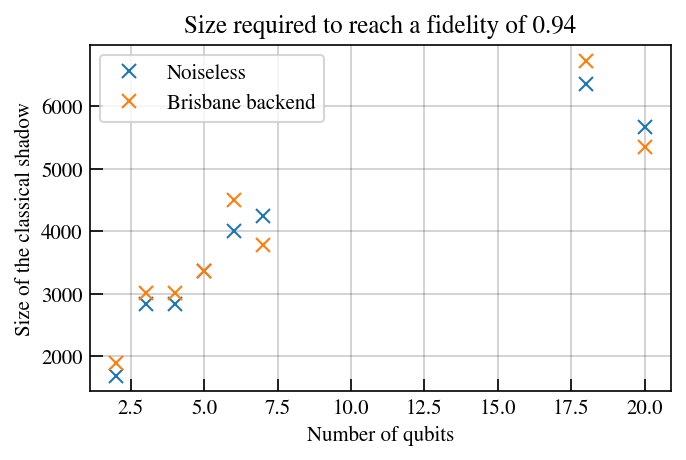

In [424]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
i = 0
for name, vals in min_size.items():
    # fit = np.polyfit(np.arange(3, 7)[vals>0], np.log(vals[vals>0]), 2)
    # x = np.linspace(3, len(vals[vals>0])+1)
    # fit_vals = np.polyval(fit, x)
    plt.plot(Range[vals>0], vals[vals>0], 'x', markersize=7, color=colors[i], label=f'{name}')
    # plt.plot(x, np.exp(fit_vals), ':', markersize=7, color=colors[i])
    i += 1

plt.grid()
plt.title(f'Size required to reach a fidelity of {1-eps}')
plt.xlabel('Number of qubits')
plt.ylabel('Size of the classical shadow')
plt.legend()
plt.savefig(f'plots/size_required_{1-eps}.pdf')

# Comparison

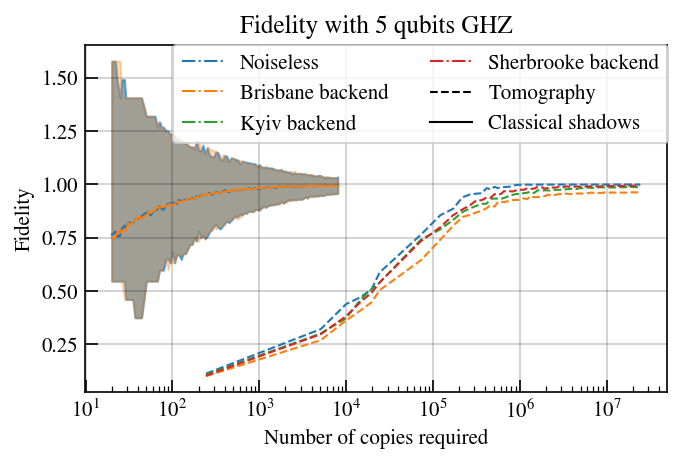

In [425]:
nqubits = 5

i = 0
for name, vals in super_fid_tomo.items():
    plt.plot(3**nqubits*nshots[nqubits], vals[nqubits], '--', color=colors[i])#, label=f'{name}')
    plt.plot(1e3, 1, '-.', color=colors[i], label=f'{name}' if name!='Noiseless QASM simulator' else 'Noiseless')
    i+=1



i=0
for name, vals in super_fid_clsh.items():
    plt.plot(sizes, vals[nqubits][:, 0], '-', color=colors[i])#, label=f'{name}')
    plt.fill_between(sizes, vals[nqubits][:, 0]-vals[nqubits][:, 1], vals[nqubits][:, 0]+vals[nqubits][:, 2], color=colors[i], alpha=0.6 if i==0 else 0.3)
    
    # plt.plot(1e3, 0, '-.', color=colors[i], label=f'{name}')
    i+=1



plt.plot(1e3, 1, 'k--', label=f'Tomography')
plt.plot(1e3, 1, 'k-', label=f'Classical shadows')

plt.title(f'Fidelity with {nqubits} qubits GHZ')
plt.legend(ncols=2, loc='upper right', bbox_to_anchor=(1.02, 1.03))
plt.ylabel('Fidelity')
plt.xlabel('Number of copies required')
# plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.savefig('plots/tomo_vs_clsh.pdf')

In [434]:
import json
test = {k:{int(key): val.tolist()} for k,v in super_fid_clsh.items() for key, val in v.items()}

with open('result.json', 'w') as fp:
    json.dump(test, fp)




In [435]:

with open('result.json', 'r') as file:
    data = json.load(file)

In [436]:
data

{'Noiseless': {'20': [[0.7645016827583313,
    0.2645002522468567,
    0.7355007014274597],
   [0.7787516963481903, 0.2787502658367157, 0.7212506878376007],
   [0.7828350335756938, 0.28283360306421923, 0.7171673506100972],
   [0.7700016880035401, 0.27000025749206547, 0.7300006961822509],
   [0.7921683758099874, 0.29216694529851284, 0.7078340083758036],
   [0.825251740694046, 0.32525031018257144, 0.674750643491745],
   [0.8044183874924978, 0.3044169569810232, 0.6955839966932932],
   [0.8048350545565287, 0.3048336240450541, 0.6951673296292623],
   [0.8151683977444966, 0.31516696723302196, 0.6015005736351016],
   [0.8355017504692077, 0.4188337327639261, 0.4978338081041973],
   [0.8414184227784475, 0.42475040507316586, 0.49191713579495755],
   [0.846418427546819, 0.42975040984153734, 0.48691713102658607],
   [0.848918429931005, 0.43225041222572336, 0.48441712864240005],
   [0.8659601128498714, 0.4492920951445898, 0.4673754457235336],
   [0.8563767703771591, 0.4397087526718775, 0.4769587881